In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import datetime as dt
!pip install yfinance
import yfinance as yf

from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 17.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
company = 'EURUSD=X'
start = dt.datetime(2021,11,20)
end = dt.datetime.now()

In [ ]:
dataset = yf.download(company,start=start, interval = "15m", end=end, progress=False)

In [4]:
dataset = pd.read_csv('ZiwoxData.csv')

In [5]:
dataset = dataset.drop(['Time'], axis=1)
dataset = dataset.rename(columns={'Volum': 'Volume'})

In [6]:
dataset

,Open,Close,High,Low,Volume
0,1.11216,1.11205,1.11217,1.11201,146
1,1.11175,1.11200,1.11206,1.11175,125
2,1.11198,1.11188,1.11200,1.11188,57
3,1.11189,1.11156,1.11192,1.11126,200
4,1.11156,1.11163,1.11165,1.11123,122
...,...,...,...,...,...
49646,1.13607,1.13588,1.13607,1.13566,194
49647,1.13587,1.13606,1.13606,1.13570,305
49648,1.13605,1.13580,1.13605,1.13575,277
49649,1.13578,1.13596,1.13596,1.13576,127


In [7]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [8]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] < dataset['long_mavg'], 1.0, 0.0)

In [9]:
dataset

,Open,Close,High,Low,Volume,short_mavg,long_mavg,signal
0,1.11216,1.11205,1.11217,1.11201,146,1.112050,1.112050,0.0
1,1.11175,1.11200,1.11206,1.11175,125,1.112025,1.112025,0.0
2,1.11198,1.11188,1.11200,1.11188,57,1.111977,1.111977,0.0
3,1.11189,1.11156,1.11192,1.11126,200,1.111873,1.111873,0.0
4,1.11156,1.11163,1.11165,1.11123,122,1.111824,1.111824,0.0
...,...,...,...,...,...,...,...,...
49646,1.13607,1.13588,1.13607,1.13566,194,1.135973,1.132464,0.0
49647,1.13587,1.13606,1.13606,1.13570,305,1.136013,1.132562,0.0
49648,1.13605,1.13580,1.13605,1.13575,277,1.136008,1.132655,0.0
49649,1.13578,1.13596,1.13596,1.13576,127,1.136037,1.132752,0.0


In [10]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [11]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,Close,High,Low,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
49646,1.13607,1.13588,1.13607,1.13566,194,1.135973,1.132464,0.0,1.135868,1.134576,1.131474,0.019372,0.527471,0.00028,0.00611,63.120153,66.533353,53.766477,38.823529,55.639575,92.837466,94.123049,93.500,94.666667,1.135973,1.134424,1.131026
49647,1.13587,1.13606,1.13606,1.13570,305,1.136013,1.132562,0.0,1.135903,1.134672,1.131520,0.018488,0.554080,0.00040,0.00614,65.978808,67.263698,53.901064,56.962025,55.360861,95.316804,94.674013,95.750,95.166667,1.136013,1.134628,1.131039
49648,1.13605,1.13580,1.13605,1.13575,277,1.136008,1.132655,0.0,1.135884,1.134744,1.131562,0.011447,0.504380,-0.00005,0.00600,58.678966,65.139549,53.674240,24.050633,39.945396,90.895296,93.016522,92.500,93.916667,1.136008,1.134828,1.131061
49649,1.13578,1.13596,1.13596,1.13576,127,1.136037,1.132752,0.0,1.135898,1.134823,1.131606,-0.005282,0.384408,0.00029,0.00586,61.585083,65.826559,53.794497,44.303797,41.772152,93.302892,93.171664,94.500,94.250000,1.136037,1.135024,1.131082
49650,1.13592,1.13591,1.13608,1.13587,132,1.136026,1.132851,0.0,1.135900,1.134893,1.131649,-0.024644,0.320592,-0.00011,0.00430,60.117013,65.409837,53.750674,33.783784,34.046071,90.373281,91.523823,93.875,93.625000,1.136026,1.135167,1.131104


In [12]:
#dataset=dataset.drop(['High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
dataset=dataset.drop(['High','Low','Open','short_mavg','long_mavg'], axis=1)

In [13]:
dataset.tail()

,Close,Volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
49646,1.13588,194,0.0,1.135868,1.134576,1.131474,0.019372,0.527471,0.00028,0.00611,63.120153,66.533353,53.766477,38.823529,55.639575,92.837466,94.123049,93.500,94.666667,1.135973,1.134424,1.131026
49647,1.13606,305,0.0,1.135903,1.134672,1.131520,0.018488,0.554080,0.00040,0.00614,65.978808,67.263698,53.901064,56.962025,55.360861,95.316804,94.674013,95.750,95.166667,1.136013,1.134628,1.131039
49648,1.13580,277,0.0,1.135884,1.134744,1.131562,0.011447,0.504380,-0.00005,0.00600,58.678966,65.139549,53.674240,24.050633,39.945396,90.895296,93.016522,92.500,93.916667,1.136008,1.134828,1.131061
49649,1.13596,127,0.0,1.135898,1.134823,1.131606,-0.005282,0.384408,0.00029,0.00586,61.585083,65.826559,53.794497,44.303797,41.772152,93.302892,93.171664,94.500,94.250000,1.136037,1.135024,1.131082
49650,1.13591,132,0.0,1.135900,1.134893,1.131649,-0.024644,0.320592,-0.00011,0.00430,60.117013,65.409837,53.750674,33.783784,34.046071,90.373281,91.523823,93.875,93.625000,1.136026,1.135167,1.131104


In [14]:
dataset = dataset.dropna(axis=0)

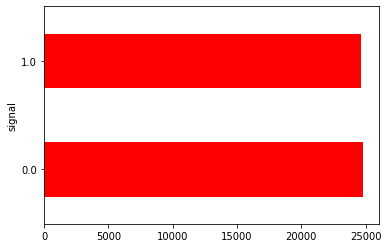

In [15]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

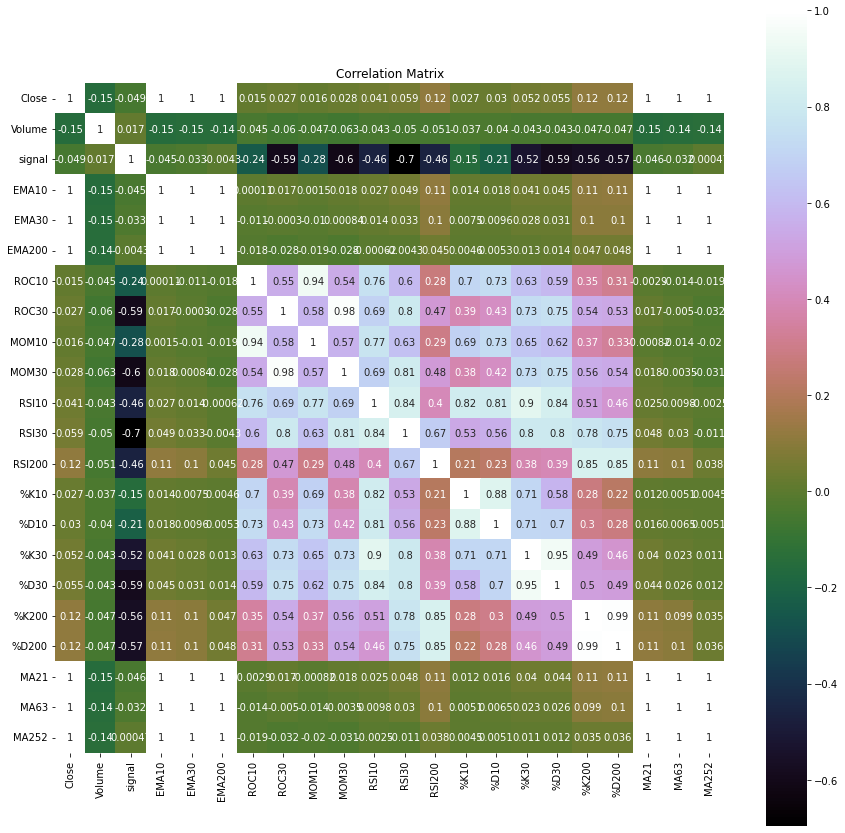

In [16]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [17]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
#X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

X_train = X[:-3000]
Y_train = Y[:-3000]
X_validation = X[-3000:]
Y_validation = Y[-3000:]


In [18]:
X_train.shape, X_validation.shape

((46450, 21), (3000, 21))

In [19]:
print(X_train.shape, X_validation.shape)
print(Y_train.shape, Y_validation.shape)

(46450, 21) (3000, 21)
(46450,) (3000,)


In [20]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.904500 (0.007272)
LDA: 0.912250 (0.009045)
KNN: 0.818125 (0.012603)
CART: 0.893500 (0.011358)
NB: 0.791125 (0.016905)
NN: 0.897625 (0.014070)
AB: 0.906375 (0.008935)
GBM: 0.924125 (0.008997)
RF: 0.940500 (0.009069)


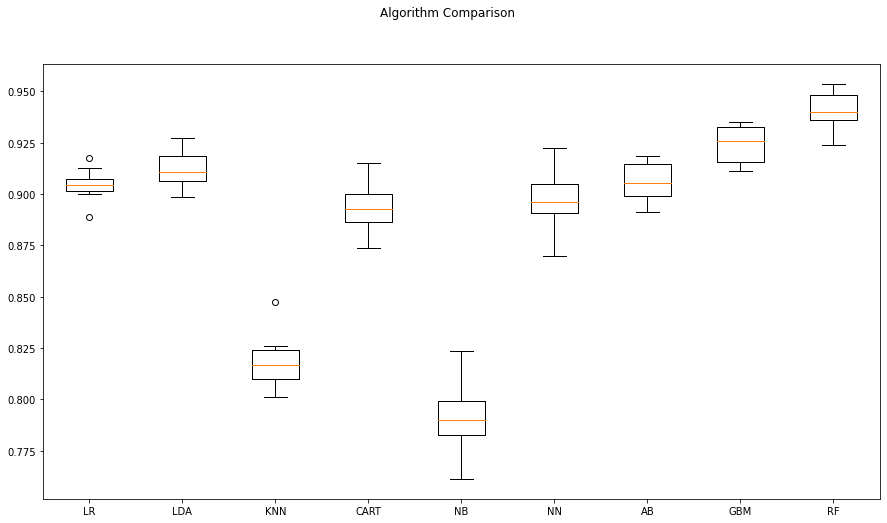

In [ ]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [ ]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.933500 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#6 0.885625 (0.012836) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.889875 (0.011284) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.928875 (0.010480) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.932250 (0.009711) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.884000 (0.011413) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#7 0.885250 (0.012013) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.928375 (0.010110) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.933500 (0.008288) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [ ]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [22]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [23]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8716666666666667
[[1328  165]
 [ 220 1287]]
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87      1493
         1.0       0.89      0.85      0.87      1507

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [24]:
predictions

array([0., 0., 0., ..., 0., 0., 0.])

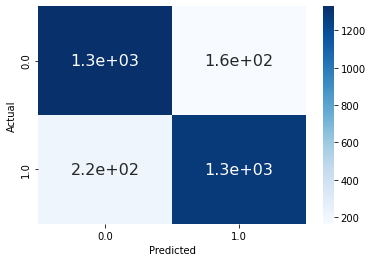

In [25]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

In [26]:
Y_validation.shape

(3000,)

Text(0.5, 0, 'Variable Importance')

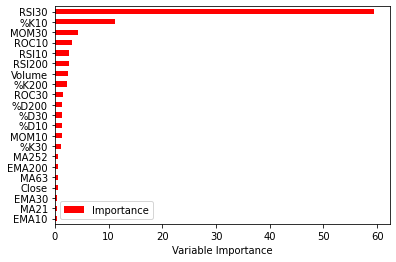

In [27]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

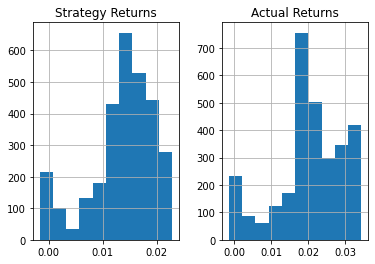

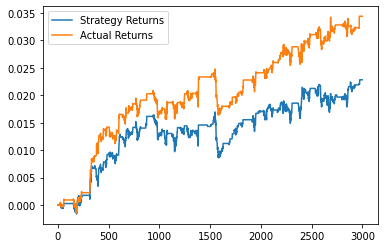

In [28]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [ ]:
!pip install emlearn

In [ ]:
import emlearn
cmodel = emlearn.convert(model, method='inline')
cmodel.save(file='eurusd.mqh')

'\n    // !!! This file is generated using emlearn !!!\n\n    #include <eml_trees.h>\n    \n\nEmlTreesNode eurusd_nodes[10387] = {\n  { 16, 50.6176643371582, 1, 66 },\n  { 14, 0.0002550482749938965, 2, 47 },\n  { 23, 59.72164535522461, 3, 35 },\n  { 13, -0.0006361007690429688, 4, 21 },\n  { 21, 38.642316818237305, 5, 17 },\n  { 16, 48.484066009521484, 6, 16 },\n  { 8, 1.136191725730896, 7, 11 },\n  { 12, -0.1521550416946411, 8, 13 },\n  { 12, -0.6037717461585999, 9, 12 },\n  { 12, -0.6150213778018951, 10, 11 },\n  { -1, 1, -1, -1 },\n  { -1, 0, -1, -1 },\n  { 12, -0.2313539832830429, 10, 10 },\n  { 19, 6.250408887863159, 14, 15 },\n  { 21, 3.8129860162734985, 10, 11 },\n  { 10, 1.1308780312538147, 10, 10 },\n  { 20, 40.0323600769043, 11, 10 },\n  { 13, -0.0007689595222473145, 18, 20 },\n  { 6, 1.1297011375427246, 19, 11 },\n  { 7, 1.1252883672714233, 11, 10 },\n  { 13, -0.0006368756294250488, 10, 11 },\n  { 2, 1.1324387192726135, 22, 32 },\n  { 9, 1.1300524473190308, 23, 30 },\n  { 4, 

In [ ]:
X_validation.columns, X_validation.shape

(Index(['Close', 'Volume', 'EMA10', 'EMA30', 'EMA200', 'ROC10', 'ROC30',
        'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%D10', '%K30',
        '%D30', '%K200', '%D200', 'MA21', 'MA63', 'MA252'],
       dtype='object'), (9890, 21))

In [29]:
!pip install m2cgen
import m2cgen as m2c 

     |████████████████████████████████| 73 kB 1.9 MB/s 


In [30]:
model_to_c = m2c.export_to_c(model, function_name='pred')
with open('eurusd.mqh', 'w') as f:
    f.write(model_to_c)